<a href="https://colab.research.google.com/github/reachel1/Freshman_learn_AI/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jul  5 09:21:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import glob
# Importing drive method from colab for accessing google drive
from google.colab import drive
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/Data')

Mounted at /Data


In [ ]:
!ls /Data/'My Drive'/dataset

cifar-10-python.tar.gz


In [ ]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#resize功能
from scipy import misc

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# 超参数设置
num_epochs = 10
num_classes = 10
batch_size = 10
learning_rate = 0.001

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 数据增广方法
transform = transforms.Compose([
    # +4填充至36x36
    transforms.Pad(4),
    # 随机水平翻转
    transforms.RandomHorizontalFlip(),
    # 随机裁剪至32x32
    transforms.RandomCrop(32),
    # 转换至Tensor
    transforms.ToTensor(),
    ])

In [ ]:
LOAD_CIFAR = True
DOWNLOAD_CIFAR = False
# 从data继承读取数据集的类
from torch.utils.data import Dataset, DataLoader
# 训练数据集
train_data = torchvision.datasets.CIFAR10(
    root='/Data/My Drive/dataset',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR,
)

# 测试数据集
test_data = torchvision.datasets.CIFAR10(
    root='/Data/My Drive/dataset',
    train=False,
    transform=transform
)


# 生成数据加载器
# 训练数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
# 测试数据加载器
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)


frog


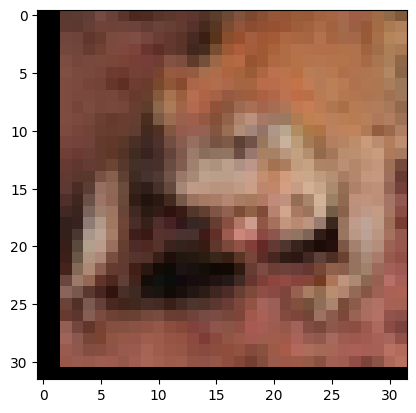

In [20]:
# 查看数据,取一组batch
data_iter = iter(test_loader)

images, labels = next(data_iter)
# 取batch中的一张图像
idx = 5
image = images[idx].numpy()
image = np.transpose(image, (1,2,0))
plt.imshow(image)
print(classes[labels[idx].numpy()])

In [ ]:
# 搭建卷积神经网络模型
# 三个卷积层
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            # 卷积层计算
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            #  批归一化
            nn.BatchNorm2d(8),
            #ReLU激活函数
            nn.ReLU(),
            # 池化层：最大池化
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))# 搭建卷积神经网络模型

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))# 搭建卷积神经网络模型

        self.fc = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(4*4*32, 120),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )

    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# 实例化一个模型
model = ConvNet(num_classes)

In [ ]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 设置cuda-gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Thu Jul  6 09:10:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [ ]:
# 开始训练
model = model.cuda()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.cuda()
        labels = labels.cuda()
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/5000], Loss: 1.9389
Epoch [1/10], Step [200/5000], Loss: 2.1814
Epoch [1/10], Step [300/5000], Loss: 1.4613
Epoch [1/10], Step [400/5000], Loss: 2.0760
Epoch [1/10], Step [500/5000], Loss: 1.5552
Epoch [1/10], Step [600/5000], Loss: 2.2862
Epoch [1/10], Step [700/5000], Loss: 1.8130
Epoch [1/10], Step [800/5000], Loss: 1.4952
Epoch [1/10], Step [900/5000], Loss: 2.1959
Epoch [1/10], Step [1000/5000], Loss: 1.7233
Epoch [1/10], Step [1100/5000], Loss: 1.8182
Epoch [1/10], Step [1200/5000], Loss: 2.2403
Epoch [1/10], Step [1300/5000], Loss: 1.3424
Epoch [1/10], Step [1400/5000], Loss: 1.5374
Epoch [1/10], Step [1500/5000], Loss: 2.1392
Epoch [1/10], Step [1600/5000], Loss: 1.9356
Epoch [1/10], Step [1700/5000], Loss: 1.6400
Epoch [1/10], Step [1800/5000], Loss: 1.6147
Epoch [1/10], Step [1900/5000], Loss: 1.7813
Epoch [1/10], Step [2000/5000], Loss: 1.4669
Epoch [1/10], Step [2100/5000], Loss: 1.3718
Epoch [1/10], Step [2200/5000], Loss: 1.6863
Epoch [1/10], Step 

In [ ]:
# 设置为评估模式
model.eval()

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [ ]:
# 输出测试集精度
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 67.73 %


In [ ]:
#  保存模型
torch.save(model.state_dict(), 'model.ckpt')

true: frog
[8]
result: ship


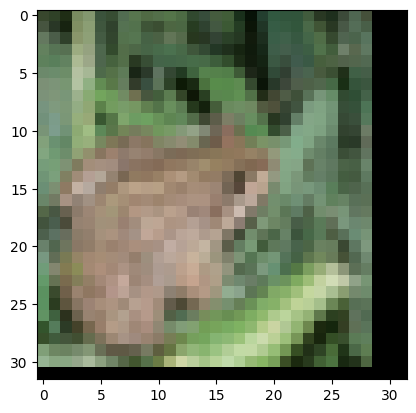

In [ ]:
# 可视化数据查看
# 查看数据,取一组batch
data_iter = iter(test_loader)
images, labels = next(data_iter)
# 取batch中的一张图像，显示图像和真实标签
idx = 4
image = images[idx].numpy()
image = np.transpose(image, (1,2,0))
plt.imshow(image)
print('true:',classes[labels[idx].numpy()])
# 转换为（B,C,H,W）大小
imagebatch = image.reshape(-1,3,32,32)

# 转换为torch tensor
image_tensor = torch.from_numpy(imagebatch)
image_tensor = image_tensor.cuda()
# 调用模型进行评估
model.eval()
output = model(image_tensor)
precise, predicted = torch.max(output.data, 1)
pre = predicted.cpu().numpy()
pci = precise.cpu().numpy()
print(pre) # 查看预测结果ID
print('result:',classes[pre[0]])
#print(pci[0])